In [3]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter#

In [7]:
general_dir = '/home/abalzer/Documents/github_clone/bachelor_thesis/pipeline/output/output_20250617_183139_latest_ML'
working_dir = os.path.join(general_dir, 'rna_isoforms')
rna_tissue_file = os.path.join(working_dir, 'transcript_rna_tissue.tsv')
gene_list_file = os.path.join(working_dir, 'gene_list.txt')

In [8]:
def load_gene_list(gene_file):
    with open(gene_file, 'r') as f:
        return set(line.strip() for line in f if line.strip())

def extract_isoform_expression(hpa_file, gene_list):
    # Load the large file in chunks
    chunks = []
    chunk_size = 100_000

    for chunk in pd.read_csv(hpa_file, sep='\t', chunksize=chunk_size):
        # Match by gene name or Ensembl ID
        matched = chunk[chunk['ensgid'].isin(gene_list) ]
        if not matched.empty:
            chunks.append(matched)

    result_df = pd.concat(chunks, ignore_index=True)
    return result_df

In [9]:

gene_list = load_gene_list(gene_list_file)
isoform_df = extract_isoform_expression(rna_tissue_file, gene_list)

isoform_df.to_csv(os.path.join(working_dir, "filtered_isoform_expression.csv"), index=False)
print(f"Saved expression data for {len(isoform_df)} isoforms.")

Saved expression data for 43 isoforms.


In [64]:
wanted_tissues = [
    "Cerebral cortex", "Cerebellum", "Basal ganglia", "Hypothalamus",
    "Midbrain", "Amygdala", "Choroid plexus", "Hippocampal formation",
    "Spinal cord", "Retina", "Thyroid gland", "Parathyroid gland",
    "Adrenal gland", "Pituitary gland", "Lung", "Salivary gland",
    "Esophagus", "Tongue", "Stomach", "Duodenum", "Small intestine",
    "Colon", "Rectum", "Liver", "Gallbladder", "Pancreas", "Kidney",
    "Urinary bladder", "Testis", "Epididymis", "Seminal vesicle",
    "Prostate", "Vagina", "Ovary", "Fallopian tube", "Endometrium",
    "Cervix", "Placenta", "Breast", "Heart muscle", "Smooth muscle",
    "Skeletal muscle", "Adipose tissue", "Skin", "Appendix", "Spleen",
    "Lymph node", "Tonsil", "Bone marrow", "Thymus"
]


In [88]:
!pip install mygene --quiet
import mygene

# Initialize once
mg = mygene.MyGeneInfo()
_id_cache = {}

def get_id(ensgid):
    if ensgid in _id_cache:
        return _id_cache[ensgid]
    try:
        result = mg.query(ensgid, scopes='ensembl.gene', fields='symbol', species='human', verbose=False)
        gene_symbol = result['hits'][0]['symbol'] if result['hits'] else None
        _id_cache[ensgid] = gene_symbol
        return gene_symbol
    except Exception as e:
        print(f"Error for {ensgid}: {e}")
        return None

In [96]:
def load_expression_data(filepath):
    return pd.read_csv(filepath)

def filter_gene_isoforms(df, gene_id):
    tpm_cols = [col for col in df.columns if col.startswith("TPM.")]
    gene_df = df[df["ensgid"] == gene_id]
    melted = gene_df[["enstid"] + tpm_cols].melt(id_vars="enstid", var_name="Tissue", value_name="TPM")
    melted["Tissue"] = melted["Tissue"].str.replace("TPM.", "", regex=False)
    melted["Tissue"] = melted["Tissue"].str.replace(r"\.\d+$", "", regex=True)
    melted["Tissue"] = melted["Tissue"].apply(lambda x: x.split(',')[0] if ',' in x else x)
    wanted_tissues_lower = [tissue.lower() for tissue in wanted_tissues]
    melted = melted[melted["Tissue"].isin(wanted_tissues_lower)]
    melted = melted.groupby(["enstid", "Tissue"], as_index=False).mean()
    return melted

def plot_isoforms_heatmap(data, gene_id, output_file=None):
    # Aggregate TPM values for the two isoforms
    aggregated_data = data.groupby(["enstid", "Tissue"], as_index=False).mean()

    # Filter for the two isoforms
    isoforms = aggregated_data["enstid"].unique() 
    filtered_data = aggregated_data[aggregated_data["enstid"].isin(isoforms)]
    filtered_data['gene'] = filtered_data['enstid'].apply(get_id)

    # Create a barplot
    plt.figure(figsize=(20, 10))
    sns.barplot(data=filtered_data, x="Tissue", y="TPM", hue="enstid", palette="viridis")
    plt.title(f"TPM Expression Barplot for Two Isoforms of Gene {get_id(gene_id)} ({gene_id})")
    plt.xlabel("Tissue")
    plt.ylabel("TPM")
    plt.xticks(rotation=45, ha='right')
    if output_file:
        plt.savefig(output_file, dpi=300)

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


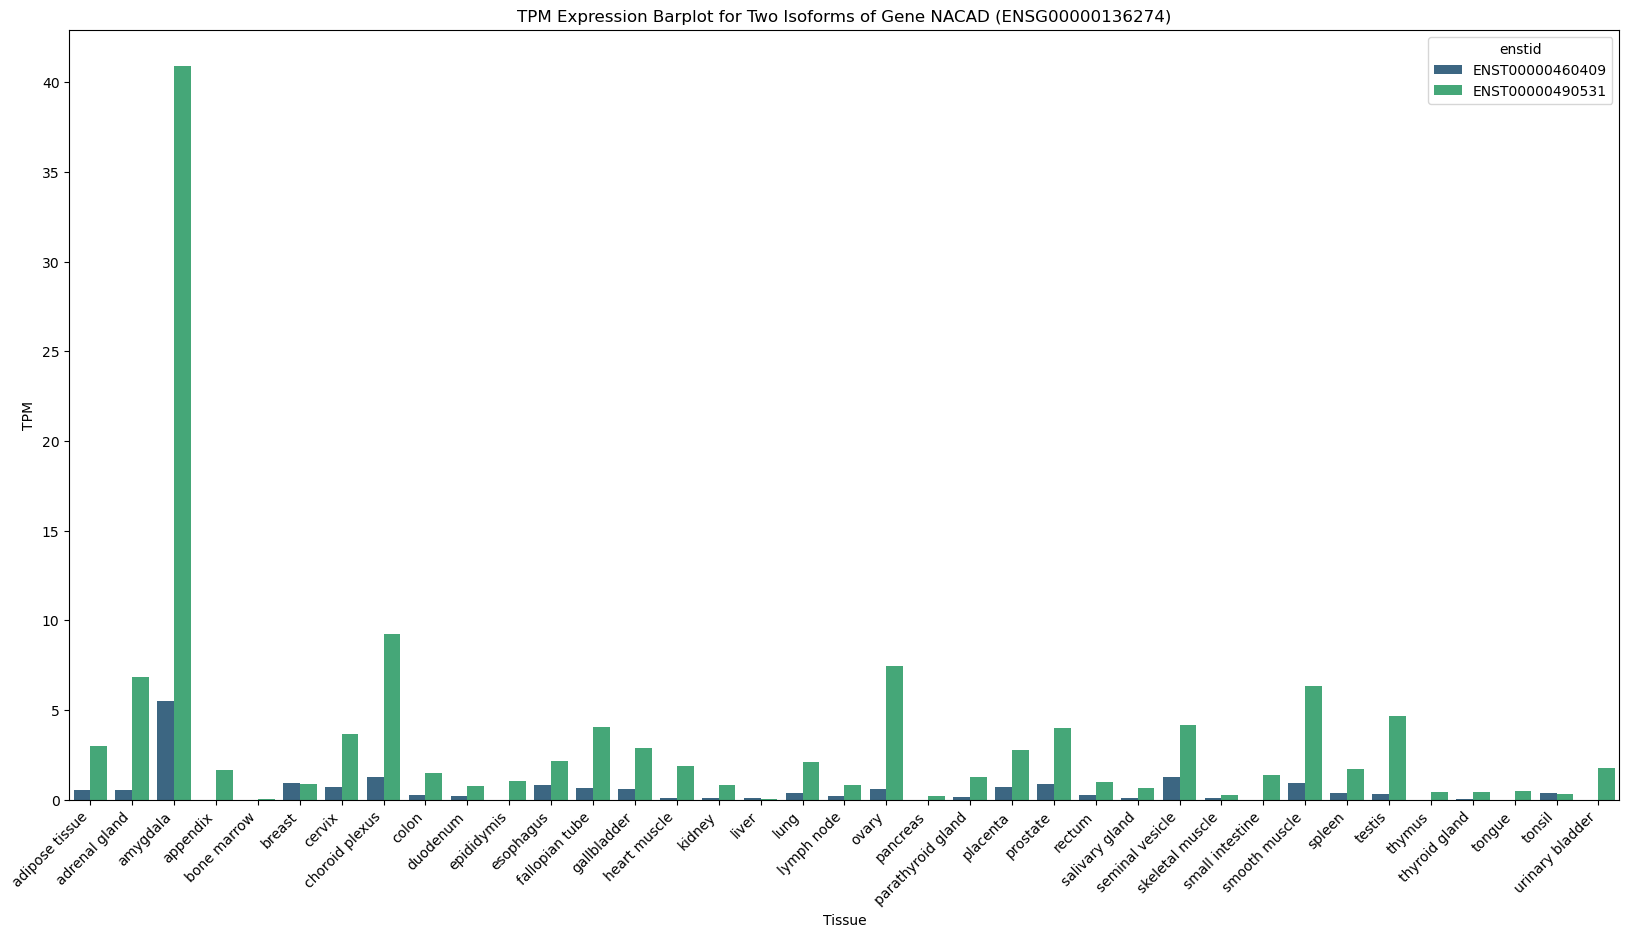

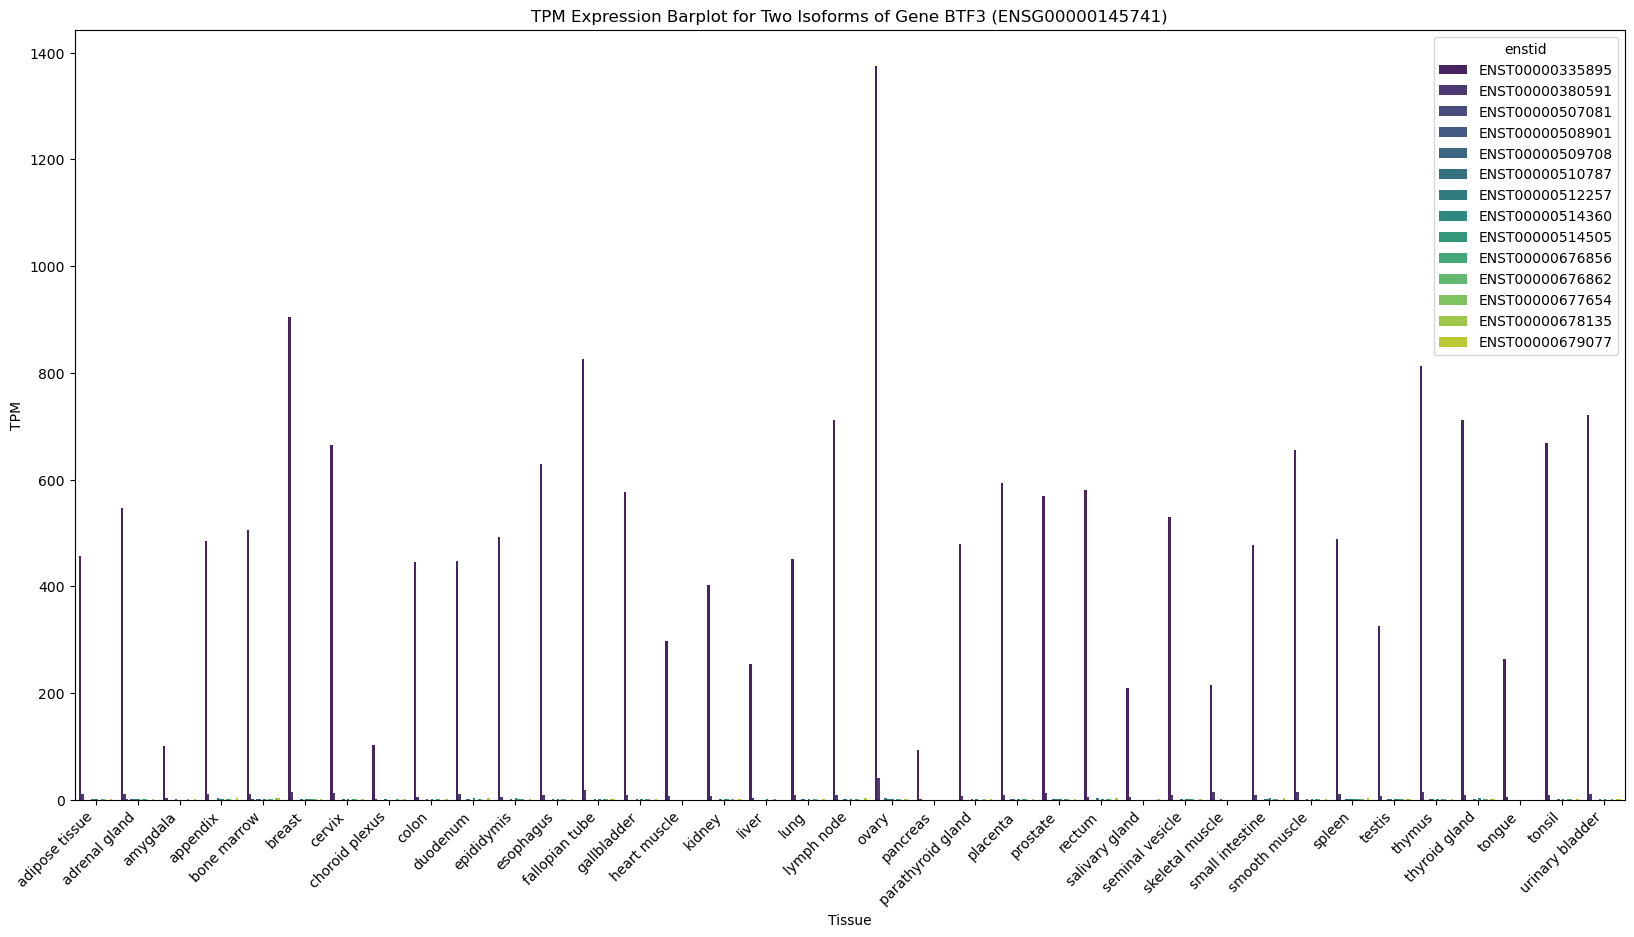

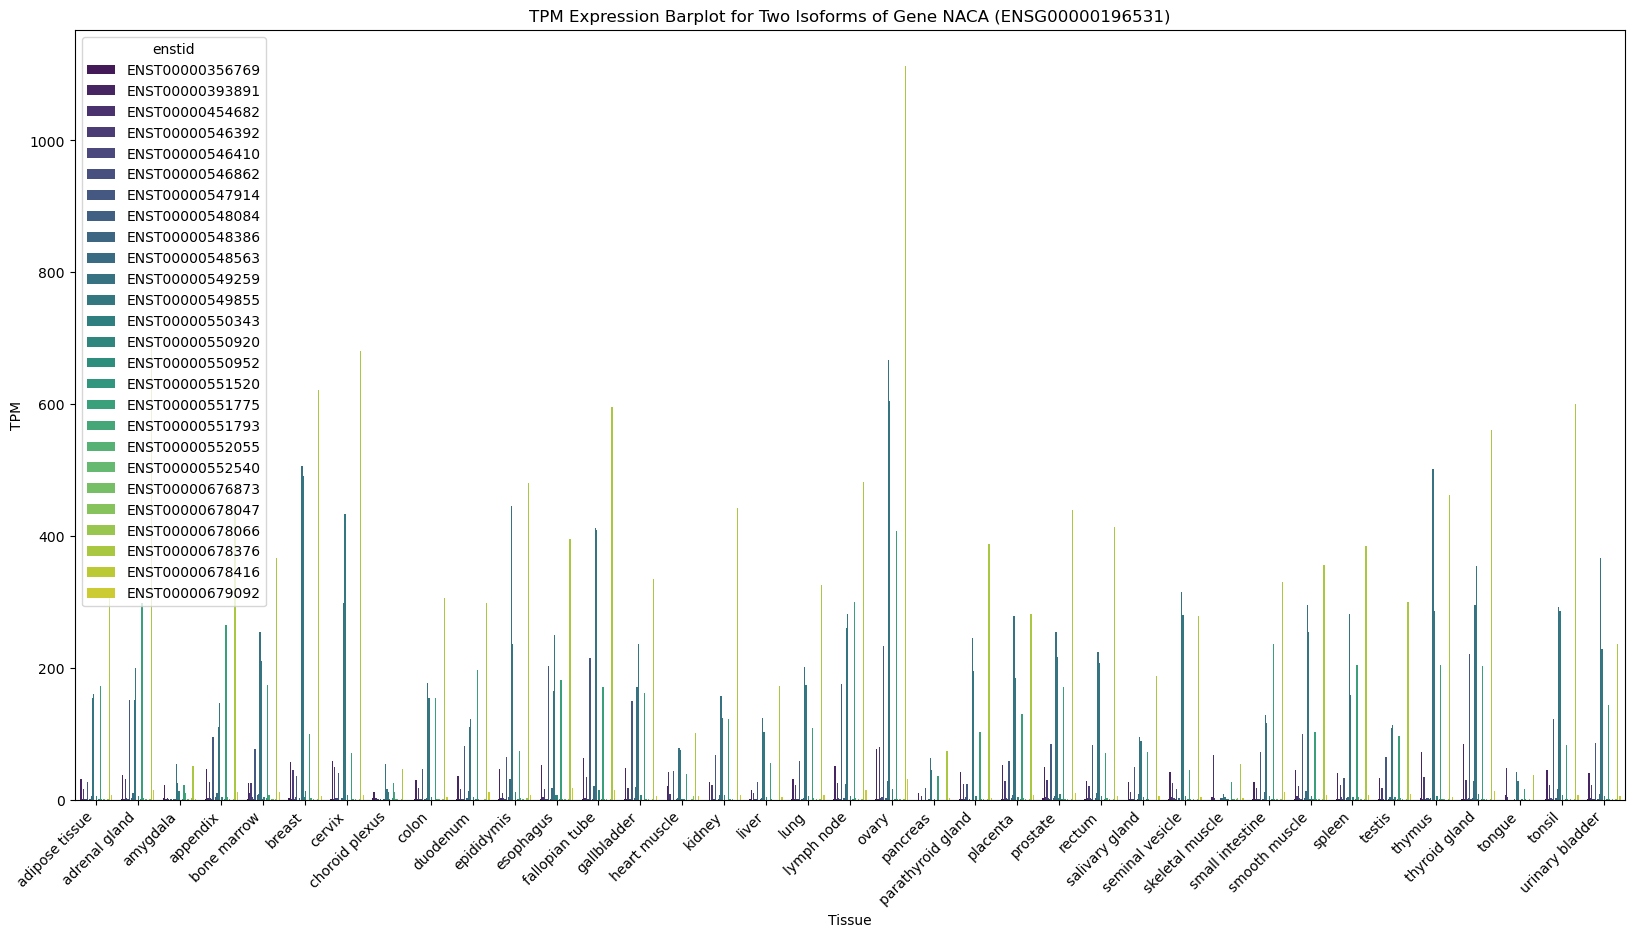

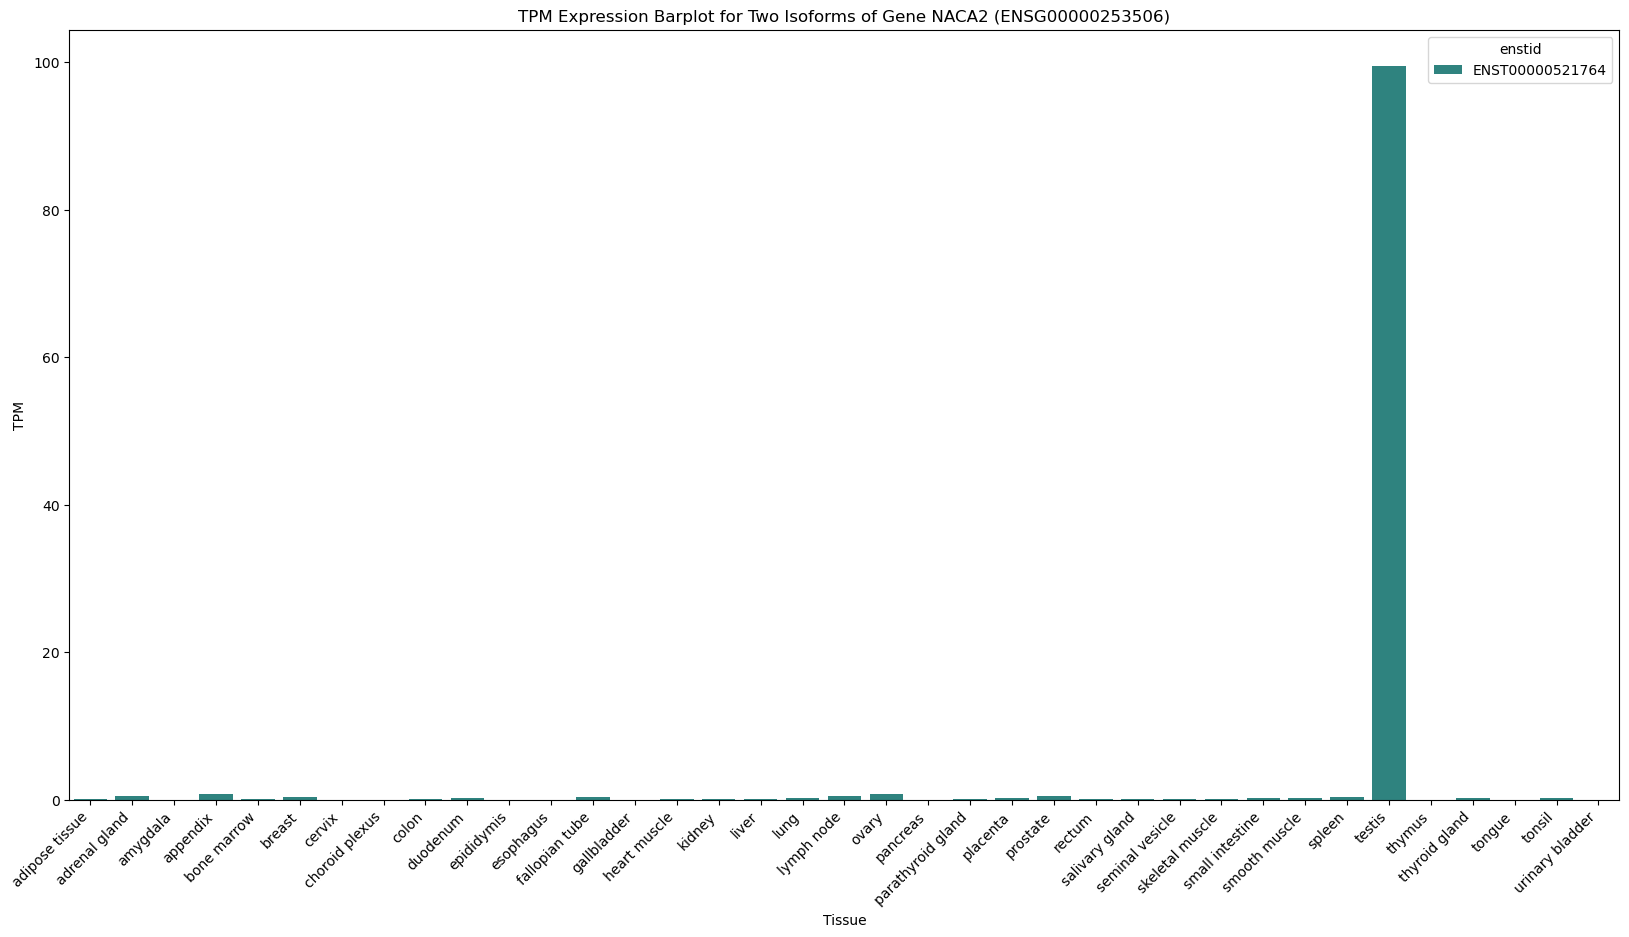

In [97]:
expression_data = load_expression_data(os.path.join(working_dir, "filtered_isoform_expression.csv"))
gene_id = "ENSG00000136274"
for gene_id in gene_list:
    isoform_data = filter_gene_isoforms(expression_data, gene_id)
    plot_isoforms_heatmap(isoform_data, gene_id, output_file=os.path.join(working_dir, f"isoform_expression_{get_id(gene_id)}.png"))